In [1]:
import numpy as np
import math
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
import time
import random
import matplotlib.pyplot as plt
import heapq
from mpl_toolkits.mplot3d import Axes3D

In [2]:
tf.VERSION

'1.12.2'

In [3]:
%matplotlib inline

## Finite Element Model of the Space Frame Element

In [4]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [5]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L
    
    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3], 
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])  
    
    
    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = math.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])
        
        
    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1), 
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)           

In [6]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]    
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]
    
    return K

In [7]:
def FEA_u(coord, elcon, bc_u_elim, f_after_u_elim, E=210e6,G=84e6,A=2e-2,Iy=10e-5,Iz=20e-5,J=5e-5):
    coord=np.array(coord)
    elcon=np.array(elcon)
    
    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))
    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
    K=np.delete(K,bc_u_elim,0)
    K=np.delete(K,bc_u_elim,1)    
    d=np.dot(np.linalg.inv(K),f_after_u_elim)        
    u=np.zeros(shape=(6*len(coord)))

    j=0
    for i in range(len(u)):
        if i not in bc_u_elim:
            u[i]=d[j]
            j+=1
            if j>len(d)-1:
                break
    return u

## Utils

In [8]:
def total_length(coord,elcon):
    coord=np.array(coord)
    elcon=np.array(elcon)
    t_length=0
    for i in range(len(elcon)):
        l=PlaneTrussElementLength(coord[elcon[i][0]][0],\
                                    coord[elcon[i][0]][1],\
                                    coord[elcon[i][0]][2],\
                                    coord[elcon[i][1]][0],\
                                    coord[elcon[i][1]][1],\
                                    coord[elcon[i][1]][2])
        t_length+=l        
    return t_length    

In [9]:
def possible_lines_dic(n,m,dx,dy):
    A=[(-dx,0),(-dx,dy),(0,dy),(dx,dy),(dx,0),(dx,-dy),(0,-dy),(-dx,-dy)]
    dic={}
    t=0
    for i in range(n):
        for j in range(m):
            for item in A:
                x,y=j*dx,i*dy
                x1,y1=x+item[0],y+item[1]
                if x1>=0 and x1<=(m-1)*dx and y1>=0 and y1<=(n-1)*dy and (x1,y1,x,y) not in dic:
                    dic[(x,y,x1,y1)]=t
                    t+=1
    return dic                

In [10]:
# def possible_elcon_dic(n,m,dx,dy):
#     dic={}
#     t=0
#     for i in range(n):
#         for j in range(m):
#             x,y=j*dx,i*dy
#             dic[(x,y)]=t
#             t+=1
            
#     return dic        
            

In [11]:
# lines_dic(5,5,1,1)

In [12]:
# possible_elcon_dic(5,5,1,1)

In [13]:
# def pad(l, content, width):
#     l.extend([content] * (width - len(l)))
#     return l

In [14]:
# def triangle(elcon):
#     c=random.randint(0,np.max(elcon))

#     T=[]
#     for i in range(len(elcon)):
#         if np.any(np.not_equal(elcon[i],elcon[c])) and elcon[c][1] in elcon[i]:
#             T+=list(elcon[i])  
            
#     T=set(T)
#     T=list(T)
    
#     for j in range(len(T)):
#         if ([elcon[c][0],T[j]] in elcon.tolist() or [T[j],elcon[c][0]] in elcon.tolist()) \
#                         and  np.any(np.not_equal(np.array([elcon[c][0],T[j]]),elcon[c])):
#             return [elcon[c][0],elcon[c][1],T[j]]

In [15]:
# def mid_point_triangle(tr_edges,coord):
#     ox=(coord[tr_edges[0]][0]+coord[tr_edges[1]][0]+coord[tr_edges[2]][0])/3
#     oy=(coord[tr_edges[0]][1]+coord[tr_edges[1]][1]+coord[tr_edges[2]][1])/3
#     oz=0
#     return list((ox,oy,oz))

In [16]:
# def new_connections(tr_edges,coord):  
#     K=tr_edges    
#     return [[len(coord),K[0]],[len(coord),K[1]],[len(coord),K[2]]]
# list(range(0,6))

## Model

In [17]:
class Model:
    def __init__(self,n=5,m=5,dx=1,dy=1, force=-500,
                 E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5, break_flag=False):
        # n,m,dx,dy - grid parameters    
        self.E=E
        self.G=G
        self.A=A
        self.Iy=Iy
        self.Iz=Iz
        self.J=J
        self.n=n
        self.m=m
        self.dx=dx
        self.dy=dy
        self.dic_lines=possible_lines_dic(self.n,self.m,self.dx,self.dy)
        self.line_list=len(self.dic_lines)*[0]
        self.break_flag=break_flag
        self.coord=[[2,2,0]]    
        self.elcon=[]  
        self.el_dic={(2,2):0}
        self.max_el=0
        self.bc_u_elim=[] 
        self.force=force
        self.f_after_u_elim=[0,self.force,0,0,0,0]
        self.old_weight=float("inf")
        self.old_strength=-float("inf")
        self.visit_list = [0,0,0,0] # number of checkpoints is 4
    
    def reset(self,break_flag,force):
        self.dic_lines=possible_lines_dic(self.n,self.m,self.dx,self.dy)
        self.line_list=len(self.dic_lines)*[0]
        self.break_flag=break_flag
        self.coord=[[2,2,0]]    
        self.elcon=[]  
        self.el_dic={(2,2):0}
        self.max_el=0
        self.bc_u_elim=[] 
        self.force=force
        self.f_after_u_elim=[0,self.force,0,0,0,0]
#         self.old_weight=-float("inf")
#         self.old_strength=-float("inf")
        self.visit_list = [0,0,0,0] # number of checkpoints is 4
    
    def FEA(self):
        return FEA_u(self.coord, self.elcon, self.bc_u_elim, self.f_after_u_elim,
                     self.E,self.G,self.A,self.Iy,self.Iz,self.J)
        
    def max_u(self,FEA_output_arr):
        t=1
        A=[]
        while t<len(FEA_output_arr):
            A.append(FEA_output_arr[t])
            t+=6            
        return min(A)    
            
    
    def length(self):
        return total_length(self.coord,self.elcon)
    
    
    def move_w(self,x,y):
        # x,y - current location
        x_new=x-self.dx
        y_new=y
        if x_new<0 or x_new>(self.m-1)*self.dx or y_new<0 or y_new>(self.n-1)*self.dy \
        or 3 in self.line_list:
            self.break_flag=True
        else:
            try:
                self.line_list[self.dic_lines[(x,y,x_new,y_new)]]+=1
            except KeyError:
                self.line_list[self.dic_lines[(x_new,y_new, x,y)]]+=1
            
            if (x_new,y_new) not in self.el_dic:
                self.max_el+=1
                self.el_dic[(x_new,y_new)]=self.max_el
                self.coord.append([x_new,y_new,0])
#                 if (x_new,y_new)!=(0,0) and (x_new,y_new)!=((self.m-1)*self.dx,0) and \
#                     (x_new,y_new)!=((self.m-1)*self.dx,(self.n-1)*self.dy) and \
#                     (x_new,y_new)!=(0,(self.n-1)*self.dy):
                if (x_new,y_new)!=(1,1) and (x_new,y_new)!=(self.m-2,1) and \
                    (x_new,y_new)!=(self.m-2,self.n-2) and \
                    (x_new,y_new)!=(1,self.n-2):
                    self.f_after_u_elim+=[0,self.force,0,0,0,0]
                elif (x_new,y_new)==(1,1) or (x_new,y_new)==(self.m-2,1) or \
                    (x_new,y_new)==(self.m-2,self.n-2) or \
                    (x_new,y_new)==(1,self.n-2):
                    self.bc_u_elim+=list(range(self.el_dic[(x_new,y_new)]*6-6,self.el_dic[(x_new,y_new)]*6))
                        
            if  (self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]) not in self.elcon and \
                 (self.el_dic[(x_new,y_new)],self.el_dic[(x,y)]) not in self.elcon:
                self.elcon.append([self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]])
            
            if (x_new,y_new) in self.el_dic:
                if (x_new,y_new)==(1,1):
                    self.visit_list[0]+=1
                elif (x_new,y_new)==(self.m-2,1):
                    self.visit_list[1]+=1
                elif (x_new,y_new)==(self.m-2,self.n-2):
                    self.visit_list[2]+=1
                elif (x_new,y_new)==(1,self.n-2):
                    self.visit_list[3]+=1
            
        return x_new, y_new
            
    def move_nw(self,x,y):
        # x,y - current location
        x_new=x-self.dx
        y_new=y+self.dy
        if x_new<0 or x_new>(self.m-1)*self.dx or y_new<0 or y_new>(self.n-1)*self.dy \
        or 3 in self.line_list:
            self.break_flag=True
        else:
            try:
                self.line_list[self.dic_lines[(x,y,x_new,y_new)]]+=1
            except KeyError:
                self.line_list[self.dic_lines[(x_new,y_new, x,y)]]+=1
            
            if (x_new,y_new) not in self.el_dic:
                self.max_el+=1
                self.el_dic[(x_new,y_new)]=self.max_el
                self.coord.append([x_new,y_new,0])
                if (x_new,y_new)!=(1,1) and (x_new,y_new)!=(self.m-2,1) and \
                    (x_new,y_new)!=(self.m-2,self.n-2) and \
                    (x_new,y_new)!=(1,self.n-2):
                    self.f_after_u_elim+=[0,self.force,0,0,0,0]
                elif (x_new,y_new)==(1,1) or (x_new,y_new)==(self.m-2,1) or \
                    (x_new,y_new)==(self.m-2,self.n-2) or \
                    (x_new,y_new)==(1,self.n-2):
                    self.bc_u_elim+=list(range(self.el_dic[(x_new,y_new)]*6-6,self.el_dic[(x_new,y_new)]*6))
                        
            if  (self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]) not in self.elcon and \
                 (self.el_dic[(x_new,y_new)],self.el_dic[(x,y)]) not in self.elcon:
                self.elcon.append([self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]]) 
                  
            if (x_new,y_new) in self.el_dic:
                if (x_new,y_new)==(1,1):
                    self.visit_list[0]+=1
                elif (x_new,y_new)==(self.m-2,1):
                    self.visit_list[1]+=1
                elif (x_new,y_new)==(self.m-2,self.n-2):
                    self.visit_list[2]+=1
                elif (x_new,y_new)==(1,self.n-2):
                    self.visit_list[3]+=1    
                
        return x_new, y_new
    
    def move_n(self,x,y):
        # x,y - current location
        x_new=x
        y_new=y+self.dy
        if x_new<0 or x_new>(self.m-1)*self.dx or y_new<0 or y_new>(self.n-1)*self.dy \
        or 3 in self.line_list:
            self.break_flag=True
        else:
            try:
                self.line_list[self.dic_lines[(x,y,x_new,y_new)]]+=1
            except KeyError:
                self.line_list[self.dic_lines[(x_new,y_new, x,y)]]+=1
            
            if (x_new,y_new) not in self.el_dic:
                self.max_el+=1
                self.el_dic[(x_new,y_new)]=self.max_el
                self.coord.append([x_new,y_new,0])
                if (x_new,y_new)!=(1,1) and (x_new,y_new)!=(self.m-2,1) and \
                    (x_new,y_new)!=(self.m-2,self.n-2) and \
                    (x_new,y_new)!=(1,self.n-2):
                    self.f_after_u_elim+=[0,self.force,0,0,0,0]
                elif (x_new,y_new)==(1,1) or (x_new,y_new)==(self.m-2,1) or \
                    (x_new,y_new)==(self.m-2,self.n-2) or \
                    (x_new,y_new)==(1,self.n-2):
                    self.bc_u_elim+=list(range(self.el_dic[(x_new,y_new)]*6-6,self.el_dic[(x_new,y_new)]*6))
                        
            if  (self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]) not in self.elcon and \
                 (self.el_dic[(x_new,y_new)],self.el_dic[(x,y)]) not in self.elcon:
                self.elcon.append([self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]])
                  
                  
            if (x_new,y_new) in self.el_dic:
                if (x_new,y_new)==(1,1):
                    self.visit_list[0]+=1
                elif (x_new,y_new)==(self.m-2,1):
                    self.visit_list[1]+=1
                elif (x_new,y_new)==(self.m-2,self.n-2):
                    self.visit_list[2]+=1
                elif (x_new,y_new)==(1,self.n-2):
                    self.visit_list[3]+=1     
        
        return x_new, y_new
    
    
    def move_ne(self,x,y):
        # x,y - current location
        x_new=x+self.dx
        y_new=y+self.dy
        if x_new<0 or x_new>(self.m-1)*self.dx or y_new<0 or y_new>(self.n-1)*self.dy \
        or 3 in self.line_list:
            self.break_flag=True
        else:
            try:
                self.line_list[self.dic_lines[(x,y,x_new,y_new)]]+=1
            except KeyError:
                self.line_list[self.dic_lines[(x_new,y_new, x,y)]]+=1
                        
            if (x_new,y_new) not in self.el_dic:
                self.max_el+=1
                self.el_dic[(x_new,y_new)]=self.max_el
                self.coord.append([x_new,y_new,0])
                if (x_new,y_new)!=(1,1) and (x_new,y_new)!=(self.m-2,1) and \
                    (x_new,y_new)!=(self.m-2,self.n-2) and \
                    (x_new,y_new)!=(1,self.n-2):
                    self.f_after_u_elim+=[0,self.force,0,0,0,0]
                elif (x_new,y_new)==(1,1) or (x_new,y_new)==(self.m-2,1) or \
                    (x_new,y_new)==(self.m-2,self.n-2) or \
                    (x_new,y_new)==(1,self.n-2):
                    self.bc_u_elim+=list(range(self.el_dic[(x_new,y_new)]*6-6,self.el_dic[(x_new,y_new)]*6))
                        
            if  (self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]) not in self.elcon and \
                 (self.el_dic[(x_new,y_new)],self.el_dic[(x,y)]) not in self.elcon:
                self.elcon.append([self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]])
                  
            if (x_new,y_new) in self.el_dic:
                if (x_new,y_new)==(1,1):
                    self.visit_list[0]+=1
                elif (x_new,y_new)==(self.m-2,1):
                    self.visit_list[1]+=1
                elif (x_new,y_new)==(self.m-2,self.n-2):
                    self.visit_list[2]+=1
                elif (x_new,y_new)==(1,self.n-2):
                    self.visit_list[3]+=1     
                  
        return x_new, y_new
    
    def move_e(self,x,y):
        # x,y - current location
        x_new=x+self.dx
        y_new=y
        if x_new<0 or x_new>(self.m-1)*self.dx or y_new<0 or y_new>(self.n-1)*self.dy \
        or 3 in self.line_list:
            self.break_flag=True
        else:
            try:
                self.line_list[self.dic_lines[(x,y,x_new,y_new)]]+=1
            except KeyError:
                self.line_list[self.dic_lines[(x_new,y_new, x,y)]]+=1
                       
                  
            if (x_new,y_new) not in self.el_dic:
                self.max_el+=1
                self.el_dic[(x_new,y_new)]=self.max_el
                self.coord.append([x_new,y_new,0])
                if (x_new,y_new)!=(1,1) and (x_new,y_new)!=(self.m-2,1) and \
                    (x_new,y_new)!=(self.m-2,self.n-2) and \
                    (x_new,y_new)!=(1,self.n-2):
                    self.f_after_u_elim+=[0,self.force,0,0,0,0]
                elif (x_new,y_new)==(1,1) or (x_new,y_new)==(self.m-2,1) or \
                    (x_new,y_new)==(self.m-2,self.n-2) or \
                    (x_new,y_new)==(1,self.n-2):
                    self.bc_u_elim+=list(range(self.el_dic[(x_new,y_new)]*6-6,self.el_dic[(x_new,y_new)]*6))
                        
            if  (self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]) not in self.elcon and \
                 (self.el_dic[(x_new,y_new)],self.el_dic[(x,y)]) not in self.elcon:
                self.elcon.append([self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]])   
                  
            if (x_new,y_new) in self.el_dic:
                if (x_new,y_new)==(1,1):
                    self.visit_list[0]+=1
                elif (x_new,y_new)==(self.m-2,1):
                    self.visit_list[1]+=1
                elif (x_new,y_new)==(self.m-2,self.n-2):
                    self.visit_list[2]+=1
                elif (x_new,y_new)==(1,self.n-2):
                    self.visit_list[3]+=1      
        return x_new, y_new
    
    def move_se(self,x,y):
        # x,y - current location
        x_new=x+self.dx
        y_new=y-self.dy
        if x_new<0 or x_new>(self.m-1)*self.dx or y_new<0 or y_new>(self.n-1)*self.dy \
        or 3 in self.line_list:
            self.break_flag=True
        else:
            try:
                self.line_list[self.dic_lines[(x,y,x_new,y_new)]]+=1
            except KeyError:
                self.line_list[self.dic_lines[(x_new,y_new, x,y)]]+=1
            
            if (x_new,y_new) not in self.el_dic:
                self.max_el+=1
                self.el_dic[(x_new,y_new)]=self.max_el
                self.coord.append([x_new,y_new,0])
                if (x_new,y_new)!=(1,1) and (x_new,y_new)!=(self.m-2,1) and \
                    (x_new,y_new)!=(self.m-2,self.n-2) and \
                    (x_new,y_new)!=(1,self.n-2):
                    self.f_after_u_elim+=[0,self.force,0,0,0,0]
                elif (x_new,y_new)==(1,1) or (x_new,y_new)==(self.m-2,1) or \
                    (x_new,y_new)==(self.m-2,self.n-2) or \
                    (x_new,y_new)==(1,self.n-2):
                    self.bc_u_elim+=list(range(self.el_dic[(x_new,y_new)]*6-6,self.el_dic[(x_new,y_new)]*6))
                        
            if  (self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]) not in self.elcon and \
                 (self.el_dic[(x_new,y_new)],self.el_dic[(x,y)]) not in self.elcon:
                self.elcon.append([self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]])
                  
            if (x_new,y_new) in self.el_dic:
                if (x_new,y_new)==(1,1):
                    self.visit_list[0]+=1
                elif (x_new,y_new)==(self.m-2,1):
                    self.visit_list[1]+=1
                elif (x_new,y_new)==(self.m-2,self.n-2):
                    self.visit_list[2]+=1
                elif (x_new,y_new)==(1,self.n-2):
                    self.visit_list[3]+=1      
        
        return x_new, y_new
    
    def move_s(self,x,y):
        # x,y - current location
        x_new=x
        y_new=y-self.dy
        if x_new<0 or x_new>(self.m-1)*self.dx or y_new<0 or y_new>(self.n-1)*self.dy \
        or 3 in self.line_list:
            self.break_flag=True 
        else:
            try:
                self.line_list[self.dic_lines[(x,y,x_new,y_new)]]+=1
            except KeyError:
                self.line_list[self.dic_lines[(x_new,y_new, x,y)]]+=1
            
            if (x_new,y_new) not in self.el_dic:
                self.max_el+=1
                self.el_dic[(x_new,y_new)]=self.max_el
                self.coord.append([x_new,y_new,0])
                if (x_new,y_new)!=(1,1) and (x_new,y_new)!=(self.m-2,1) and \
                    (x_new,y_new)!=(self.m-2,self.n-2) and \
                    (x_new,y_new)!=(1,self.n-2):
                    self.f_after_u_elim+=[0,self.force,0,0,0,0]
                elif (x_new,y_new)==(1,1) or (x_new,y_new)==(self.m-2,1) or \
                    (x_new,y_new)==(self.m-2,self.n-2) or \
                    (x_new,y_new)==(1,self.n-2):
                    self.bc_u_elim+=list(range(self.el_dic[(x_new,y_new)]*6-6,self.el_dic[(x_new,y_new)]*6))
                        
            if  (self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]) not in self.elcon and \
                 (self.el_dic[(x_new,y_new)],self.el_dic[(x,y)]) not in self.elcon:
                self.elcon.append([self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]])
                  
            if (x_new,y_new) in self.el_dic:
                if (x_new,y_new)==(1,1):
                    self.visit_list[0]+=1
                elif (x_new,y_new)==(self.m-2,1):
                    self.visit_list[1]+=1
                elif (x_new,y_new)==(self.m-2,self.n-2):
                    self.visit_list[2]+=1
                elif (x_new,y_new)==(1,self.n-2):
                    self.visit_list[3]+=1      
        
        return x_new, y_new
    
    def move_sw(self,x,y):
        # x,y - current location
        x_new=x-self.dx
        y_new=y-self.dy
        if x_new<0 or x_new>(self.m-1)*self.dx or y_new<0 or y_new>(self.n-1)*self.dy \
        or 3 in self.line_list:
            self.break_flag=True
        else:
            try:
                self.line_list[self.dic_lines[(x,y,x_new,y_new)]]+=1
            except KeyError:
                self.line_list[self.dic_lines[(x_new,y_new, x,y)]]+=1
                        
            if (x_new,y_new) not in self.el_dic:
                self.max_el+=1
                self.el_dic[(x_new,y_new)]=self.max_el
                self.coord.append([x_new,y_new,0])
                if (x_new,y_new)!=(1,1) and (x_new,y_new)!=(self.m-2,1) and \
                    (x_new,y_new)!=(self.m-2,self.n-2) and \
                    (x_new,y_new)!=(1,self.n-2):
                    self.f_after_u_elim+=[0,self.force,0,0,0,0]
                elif (x_new,y_new)==(1,1) or (x_new,y_new)==(self.m-2,1) or \
                    (x_new,y_new)==(self.m-2,self.n-2) or \
                    (x_new,y_new)==(1,self.n-2):
                    self.bc_u_elim+=list(range(self.el_dic[(x_new,y_new)]*6-6,self.el_dic[(x_new,y_new)]*6))
                        
            if  (self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]) not in self.elcon and \
                 (self.el_dic[(x_new,y_new)],self.el_dic[(x,y)]) not in self.elcon:
                self.elcon.append([self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]])
                  
                  
            if (x_new,y_new) in self.el_dic:
                if (x_new,y_new)==(1,1):
                    self.visit_list[0]+=1
                elif (x_new,y_new)==(self.m-2,1):
                    self.visit_list[1]+=1
                elif (x_new,y_new)==(self.m-2,self.n-2):
                    self.visit_list[2]+=1
                elif (x_new,y_new)==(1,self.n-2):
                    self.visit_list[3]+=1    
                                  
        return x_new, y_new
    
        
    def action_space(self,action,x0,y0):
        if action==0:
            return self.move_w(x0,y0)
        elif action==1:    
            return self.move_nw(x0,y0)
        elif action==2:  
            return self.move_n(x0,y0)
        elif action==3:
            return self.move_ne(x0,y0)
        elif action==4:
            return self.move_e(x0,y0)
        elif action==5:
            return self.move_se(x0,y0)
        elif action==6:
            return self.move_s(x0,y0)
        elif action==7:
            return self.move_sw(x0,y0)
                        
    
    def nn_input(self,x,y):  
        return self.line_list+[x,y]        
    
    def reward_(self,x_new,y_new,n_steps):
        reward=2*n_steps
#         reward=2
        if all([x>=1 for x in self.visit_list]):
            reward+=10000
            weight=self.length()
            
#             self.draw("green")
            FEA_output_arr=self.FEA()
            max_=self.max_u(FEA_output_arr)
            strength=max_
#             print(weight,strength) 
            if weight<=self.old_weight:
                reward+=50000
                self.old_weight=weight
            if strength>=self.old_strength: 
                reward+=100000000
                self.old_strength=strength
#             print(self.old_weight, self.old_strength)        
            self.break_flag=True     
            return reward 
#         elif any([x==1 for x in self.visit_list]):
#             reward+=250*(self.visit_list[0]+self.visit_list[1]+self.visit_list[2]+self.visit_list[3])    
#             return reward        
#         if x_new<0+1 or x_new>(self.m-1)*self.dx-1 or y_new<0+1 or y_new>(self.n-1)*self.dy-1:
#             reward-=50
#             return reward
        return reward     
                                   
    def draw(self,color):
        c=self.coord
        e=self.elcon
        c=np.array(c)
        e=np.array(e)
        coord=c.reshape(np.max(e)+1,3)
        fig=plt.figure(figsize=(13,5))
        for item in e:
            ax = fig.gca(projection='3d') 
            ax.plot([coord[item[0]][0],coord[item[1]][0]],\
                     [coord[item[0]][1],coord[item[1]][1]],\
                     [coord[item[0]][2],coord[item[1]][2]],
                     color=color) 
#             ax.view_init(70,300)
        ax.view_init(-90,90)
#         ax1 = plt.subplot(131)
        ax.set_xlim([0, 5])
        ax.set_ylim([0, 5])
        plt.show()             
    
   

## Neural Network Policy - Policy Gradients

In [18]:
n_inputs = 74 
n_hidden = 250 
n_outputs = 8 
initializer = tf.contrib.layers.variance_scaling_initializer()

learning_rate = 0.0001

# Build the neural network
X_ = tf.placeholder(tf.float64, shape=[None, n_inputs], name="X_")
hidden = fully_connected(X_, n_hidden, activation_fn=tf.nn.elu, weights_initializer=initializer)
hidden1 = fully_connected(hidden, n_hidden, activation_fn=tf.nn.elu, weights_initializer=initializer)
hidden2 = fully_connected(hidden1, n_hidden, activation_fn=tf.nn.elu, weights_initializer=initializer)
logits = fully_connected(hidden2, n_outputs, activation_fn=None, weights_initializer=initializer)
outputs = tf.nn.softmax(logits, name="Y_proba")
# outputs  = tf.exp(logits) / tf.reduce_sum(tf.exp(logits), -1)


# Select a random action based on the estimated probabilities
action = tf.random.multinomial(tf.log(outputs), num_samples=1,output_dtype=tf.int64)


y=tf.reshape(tf.one_hot(action,depth=8,dtype=tf.float64),[8,1])
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=tf.transpose(logits))

optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(xentropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float64, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))

training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [19]:
# with tf.Session() as sess:
#     A=sess.run(tf.exp([-0.39514669, -0.9955475,   0.36458025,  0.02534027,  1.11079987, -0.25412942,
#    0.68900028,  0.42532931]) /tf.reduce_sum(tf.exp([-0.39514669, -0.9955475,   0.36458025,  0.02534027,  1.11079987, -0.25412942,
#    0.68900028,  0.42532931]), -1))

In [20]:
# A

In [21]:
def discount_rewards(rewards, discount_rate=0.99):
    discounted_rewards = np.empty(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

In [22]:
def discount_and_normalize_rewards(all_rewards, discount_rate=0.99):
    all_discounted_rewards = [discount_rewards(rewards) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

In [23]:
# coord=np.array([0,0,0,0,7,0,7,7,0,7,0,0,3.5,3.5,0,4,4,0,3,4,0])
# elcon=np.array([[0,1],[1,2],[2,3],[0,3],[1,6],[2,6],[2,5],[4,5],[4,6],[0,4],[3,4],[3,5],[5,6],[0,6]])
# bc_u_elim=list(range(30,42))
# f_after_u_elim=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-500,0,0,0,0]

In [24]:
# G=Geometry(coord,elcon,bc_u_elim,f_after_u_elim)
M=Model() 

In [25]:
n_iterations = 1001 #251 # number of training iterations
n_max_steps = 500 # max steps per episode
n_games_per_update = 10 # train the policy every 10 episodes
save_iterations = 100 # save the model every 10 training iterations


with tf.Session() as sess:
    start=time.time()
    init.run() 
    
#     saver.restore(sess, tf.train.latest_checkpoint("C:\\Temp\\tf_save\\policy0\\"))    
#     tf.get_default_graph()
    
    for iteration in range(n_iterations):
               
        all_rewards = [] # all sequences of raw rewards for each episode
        all_gradients = [] # gradients saved at each step of each episode
        
        
        for game in range(n_games_per_update):
#             tf.random.set_random_seed(game)
#             init.run() # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            current_rewards = [] # all raw rewards from the current episode
            current_gradients = [] # all gradients from the current episode
    
           
            M.reset(False,-500)
           
            x0,y0=2,2
            obs=M.nn_input(x0,y0)
            
            for step in range(n_max_steps):
 
                action_val, gradients_val = sess.run([action, gradients],
                                                     feed_dict={X_: np.array(obs).reshape(1,n_inputs)})
                
#                 outputs_, gradients_val = sess.run([X_, gradients],
#                                                      feed_dict={X_: np.array(obs).reshape(1,n_inputs)})
                x_new,y_new=x0,y0 
#                 print(outputs_)
#                 print(x_new,y_new)
#                 print(action_val[0][0])
    
                x_new,y_new=M.action_space(action_val[0][0],x_new,y_new)

                                  
                
                obs=M.nn_input(x_new,y_new)
                
                   
                reward=M.reward_(x_new,y_new,step)
                x0,y0 = x_new,y_new
 
                if M.break_flag:
                    reward-=10000
                   
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
            
                if M.break_flag:
                    break 

            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

    
            
        # At this point we have run the policy for 10 episodes, and we are
        # ready for a policy update using the algorithm described earlier.
        all_rewards = discount_and_normalize_rewards(all_rewards)
        
        
        
        feed_dict = {}
        for var_index, grad_placeholder in enumerate(gradient_placeholders):
            # multiply the gradients by the action scores, and compute the mean
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index] 
                                      for game_index, rewards in enumerate(all_rewards)
                                      for step, reward in enumerate(rewards)],axis=0)
            feed_dict[grad_placeholder] = mean_gradients
        
        
        sess.run(training_op, feed_dict=feed_dict)
        
        if iteration % save_iterations == 0:
#             print("Saving {} iteration".format(iteration))
            print('Time taken for {} epoch {} sec\n'.format(iteration, time.time() - start))
            saver.save(sess, "C:\\Temp\\tf_save\\policy0\\bionic0.ckpt")

# end=time.time()

Time taken for 0 epoch 0.9420537948608398 sec

Time taken for 100 epoch 79.43754363059998 sec

Time taken for 200 epoch 180.6303312778473 sec

Time taken for 300 epoch 273.0896198749542 sec

Time taken for 400 epoch 366.36595487594604 sec

Time taken for 500 epoch 458.7122366428375 sec

Time taken for 600 epoch 556.902853012085 sec

Time taken for 700 epoch 653.9034011363983 sec

Time taken for 800 epoch 747.6687643527985 sec

Time taken for 900 epoch 858.321093082428 sec

Time taken for 1000 epoch 959.0818564891815 sec



## AI designing the bionic partition

In [26]:
def predict(G2):
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph('C:\\Temp\\tf_save\\policy0\\bionic0.ckpt.meta')
        saver.restore(sess, "C:\\Temp\\tf_save\\policy0\\bionic0.ckpt") 

        graph = tf.get_default_graph()
        outputs = graph.get_tensor_by_name("Y_proba:0") 
        X_ = graph.get_tensor_by_name("X_:0") 
                
#         G2.reset(np.array([0,0,0,0,7,0,7,7,0,7,0,0,3.5,3.5,0,4,4,0,3,4,0]),\
#         np.array([[0,1],[1,2],[2,3],[0,3],[1,6],[2,6],[2,5],[4,5],[4,6],[0,4],[3,4],[3,5],[5,6],[0,6]]),\
#         list(range(30,42)),[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-500,0,0,0,0])    
    
#         G2.position = random.randint(5,np.max(G2.elcon))

        x0,y0=2,2
        obs=G2.nn_input(x0,y0)
        
        for step in range(100):
            action_val= sess.run([outputs],feed_dict={X_: np.array(obs).reshape(1,n_inputs)})
            
            print(np.argmax(action_val))
            
            x_new,y_new=x0,y0 
            
            x_new,y_new=G2.action_space(np.argmax(action_val),x_new,y_new)
            print(x_new, y_new)
            
                
            if G2.break_flag:
                obs=G2.nn_input(x_new,y_new)
                break                     
            
            obs=G2.nn_input(x_new,y_new)
            x0,y0=x_new,y_new
#             print(obs[-1])
            
#             G2.position = random.randint(5,np.max(G2.elcon))

        G2.draw('blue')
        
        return obs[-1], obs[-2]

In [27]:
# coord=np.array([0,0,0,0,7,0,7,7,0,7,0,0,3.5,3.5,0,4,4,0,3,4,0])
# elcon=np.array([[0,1],[1,2],[2,3],[0,3],[1,6],[2,6],[2,5],[4,5],[4,6],[0,4],[3,4],[3,5],[5,6],[0,6]])
# bc_u_elim=list(range(30,42))
# f_after_u_elim=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-500,0,0,0,0]

In [28]:
M=Model()

In [29]:
# G3.draw('green')

In [30]:
# pr=G3.nn_input()

In [31]:
# pr[-1],pr[-2]

In [32]:
# G3.add_node()
# G3.add_node()
# G3.add_node()
# G3.add_node()
# G3.add_node()
# G3.add_node()
# G3.add_node()
# G3.add_node()

INFO:tensorflow:Restoring parameters from C:\Temp\tf_save\policy0\bionic0.ckpt
7
1 1
2
1 2
2
1 3
2
1 4
5
2 3
2
2 4
5
3 3
2
3 4
5
4 3
7
3 2
2
3 3
7
2 2
2
2 3
5
3 2
7
2 1
5
3 0
2
3 1
7
2 0
2
2 1
5
3 0
2
3 1
7
2 0
2
2 1
5
3 0
2
3 1


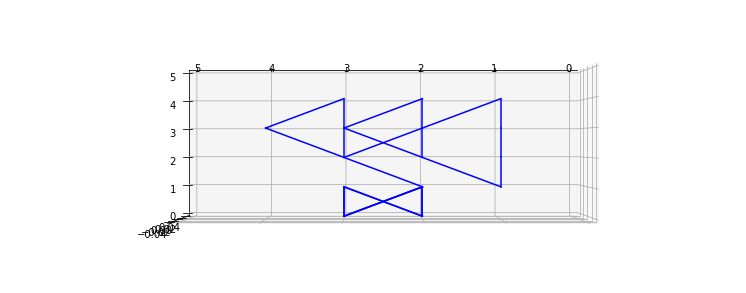

(1, 3)

In [33]:
predict(M)

In [34]:
M.length()

29.384776310850242

In [35]:
FEA_output_arr=M.FEA()
M.max_u(FEA_output_arr)

-0.0034600350278240753